# Adversarial Search: Playing Connect 4

Student Name: **Davis Vercher**

I have used the following AI tools: **ChatGPT-4**

I understand that my submission needs to be my own work: **DRV**

## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

Initial State:
- Empty 6x7 grid (standard size, could be smaller or larger but is not typical). No discs placed in the grid spaces at the beginning of the game

Actions:
- Dropping a disc into a single column that is not full. This will result in that dropped disc occupying the lowest open slot in that column
- Both players have their own color discs, and each player's action results in the placement of only their color disc. Players alternate turns dropping discs.

Transition Model:
- Each time a disc is dropped, the model updates the game board state to include the newly dropped disc at the previously lowest open slot in the column in which it was dropped.

Goal State:
- One color of discs makes a straight line of connected discs of like color (horizontal, vertical, or diagonal)
- The first player to reach the goal state with their discs wins.
- The utility of a win is represented by a 1, a loss by a -1, and a draw by a 0
- A terminal state (game ends without the goal state reached by either player) if all the spaces on the grid are filled without either player having a straight line of their four connected discs.

How big is the state space? Give an estimate and explain it.

**Estimated State Space:** Less than 1.09x10^20

- Given that there are 42 spaces (6x7), and each space can be in three states (player 1 disc, player 2 disc, empty), I initially thought the state space would be 3^42 or 1.09x10^20.
- I realized that this would not make sense because each column has fewer possibilities for disc placement since discs, once placed, automatically fall down to the lowest point in that column. This would make each column's state space smaller.
- I am not sure how to calculate this (hence the answer)

How big is the game tree that minimax search will go through? Give an estimate and explain it.

**Estimated size of the game tree:** ~4.5^25 or 2.14x10^16
- The branching factor at the start of the game is 7 for each column, but decreases as the columns fill up, leaving us with a likely average branching factor of ~4 to 5
- The maximum depth is 42 (every space being filled to end the game), but since most games don't result in all 42 spaces being filled, a reasonable estimate for the average depth of a game would be half to 2/3rds of the spaces available (~21 to 28)

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [51]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

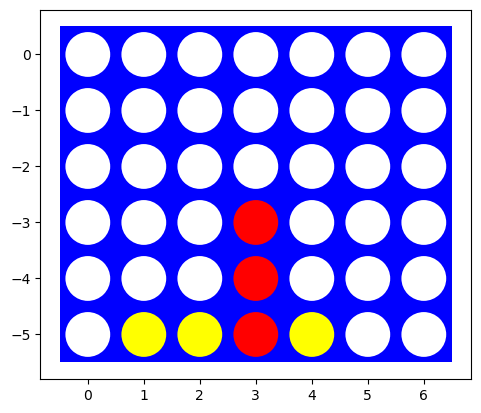

In [52]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [53]:
def actions(s):
    return [col for col in range(s.shape[1]) if s[0, col] == 0]


def result(s, a, player):
    new_state = s.copy()
    for row in range(s.shape[0] - 1, -1, -1):
        if new_state[row, a] == 0:
            new_state[row, a] = player
            break
    return new_state


def terminal(s):
    rows, cols = s.shape

    for row in range(rows):
        for col in range(cols):
            if s[row, col] != 0:
                if col <= cols - 4 and all(s[row, col] == s[row, c] for c in range(col, col + 4)):
                    return True
                if row <= rows - 4 and all(s[row, col] == s[r, col] for r in range(row, row + 4)):
                    return True
                if row <= rows - 4 and col <= cols - 4 and all(s[row, col] == s[row + i, col + i] for i in range(4)):
                    return True
                if row <= rows - 4 and col >= 3 and all(s[row, col] == s[row + i, col - i] for i in range(4)):
                    return True

    if np.all(s != 0):
        return True

    return False

def utility(s, player):
    rows, cols = s.shape

    for row in range(rows):
        for col in range(cols):
            if s[row, col] != 0:
                if col <= cols - 4 and all(s[row, col] == s[row, c] for c in range(col, col + 4)):
                    return 1 if s[row, col] == player else -1
                if row <= rows - 4 and all(s[row, col] == s[r, col] for r in range(row, row + 4)):
                    return 1 if s[row, col] == player else -1
                if row <= rows - 4 and col <= cols - 4 and all(s[row, col] == s[row + i, col + i] for i in range(4)):
                    return 1 if s[row, col] == player else -1
                if row <= rows - 4 and col >= 3 and all(s[row, col] == s[row + i, col - i] for i in range(4)):
                    return 1 if s[row, col] == player else -1

    if np.all(s != 0):
        return 0

    return 0

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [54]:
import random

def random_player(board, player=1):
    available_actions = actions(board)

    if available_actions:
        return random.choice(available_actions)
    else:
        return None

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [55]:
def play_game():
    board = empty_board()
    player = 1

    while not terminal(board):
        action = random_player(board, player)
        if action is not None:
            board = result(board, action, player)
            player *= -1
        else:
            break

    return utility(board, 1)

In [56]:
num_games = 1000
results = {"Player 1 Wins": 0, "Player -1 Wins": 0, "Draws": 0}

for _ in range(num_games):
    outcome = play_game()
    if outcome == 1:
        results["Player 1 Wins"] += 1
    elif outcome == -1:
        results["Player -1 Wins"] += 1
    else:
        results["Draws"] += 1

print("Results after 1000 games:")
print(results)

Results after 1000 games:
{'Player 1 Wins': 560, 'Player -1 Wins': 438, 'Draws': 2}


## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points] 

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [57]:
import time

In [58]:
class MinimaxAgent:
    def __init__(self, player, depth_limit=4):
        self.player = player
        self.depth_limit = depth_limit

    def minimax(self, state, depth, alpha, beta, maximizing_player):
        if terminal(state) or depth == 0:
            return utility(state, self.player), None, 1  # return 1 for one node visited

        if maximizing_player:
            max_eval = float('-inf')
            best_action = None
            nodes_explored = 0
            for action in actions(state):
                eval, _, nodes = self.minimax(result(state, action, self.player), depth - 1, alpha, beta, False)
                nodes_explored += nodes
                if eval > max_eval:
                    max_eval = eval
                    best_action = action
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval, best_action, nodes_explored
        else:
            min_eval = float('inf')
            best_action = None
            nodes_explored = 0
            for action in actions(state):
                eval, _, nodes = self.minimax(result(state, action, -self.player), depth - 1, alpha, beta, True)
                nodes_explored += nodes
                if eval < min_eval:
                    min_eval = eval
                    best_action = action
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval, best_action, nodes_explored

    def choose_action(self, state, depth=4):
        start_time = time.time()
        _, action, nodes_explored = self.minimax(state, depth, float('-inf'), float('inf'), True)
        end_time = time.time()
        time_taken = end_time - start_time
        return action, time_taken, nodes_explored


In [59]:
agent = MinimaxAgent(player=1)

**Board 0:** Simple Horizontal

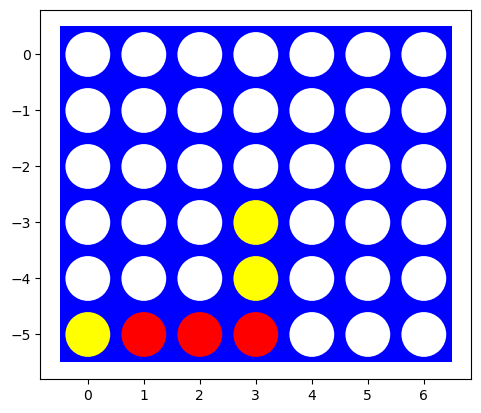

In [60]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0,-1, 0, 0, 0],
             [ 0, 0, 0,-1, 0, 0, 0],
             [-1, 1, 1, 1, 0, 0, 0]]
visualize(raw_board)
board = np.array(raw_board)

In [61]:
action, time_taken, nodes_explored = agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {time_taken:.4f} seconds\nNodes explored: {nodes_explored}")

Next action: drop disc in column 4
Time taken: 0.0358 seconds
Nodes explored: 187


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

**Board 1:** Left Diagonal

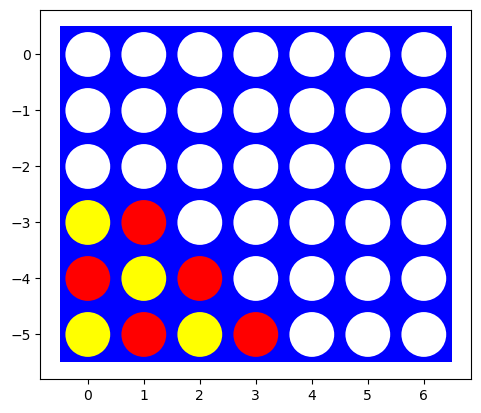

In [62]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [-1, 1, 0, 0, 0, 0, 0],
             [ 1,-1, 1, 0, 0, 0, 0],
             [-1, 1,-1, 1, 0, 0, 0]]

visualize(raw_board)
board = np.array(raw_board)

In [63]:
action, time_taken, nodes_explored = agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {time_taken:.4f} seconds\nNodes explored: {nodes_explored}")

Next action: drop disc in column 0
Time taken: 0.0081 seconds
Nodes explored: 43


**Board 2:** Nearly Full Board

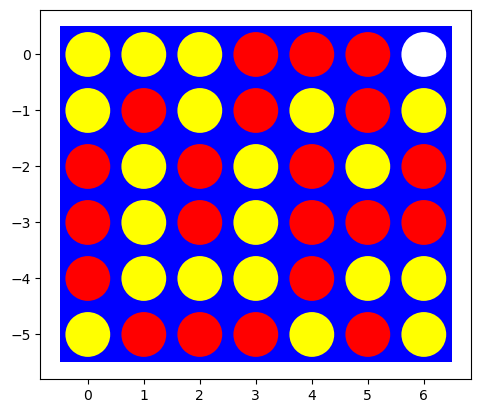

In [64]:
raw_board = [[-1,-1,-1, 1, 1, 1, 0],
             [-1, 1,-1, 1,-1, 1,-1],
             [ 1,-1, 1,-1, 1,-1, 1],
             [ 1,-1, 1,-1, 1, 1, 1],
             [ 1,-1,-1,-1, 1,-1,-1],
             [-1, 1, 1, 1,-1, 1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [65]:
action, time_taken, nodes_explored = agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {time_taken:.4f} seconds\nNodes explored: {nodes_explored}")

Next action: drop disc in column None
Time taken: 0.0000 seconds
Nodes explored: 1


**Board 3:** Simple Vertical

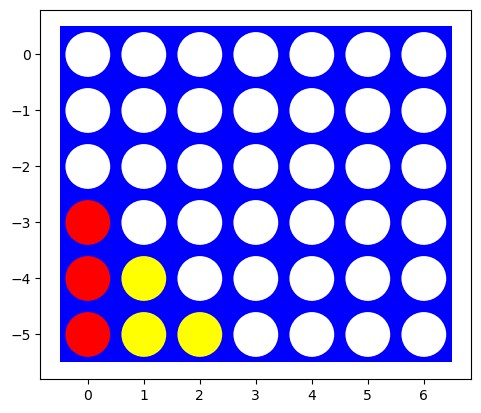

In [66]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 1, 0, 0, 0, 0, 0, 0],
             [ 1,-1, 0, 0, 0, 0, 0],
             [ 1,-1,-1, 0, 0, 0, 0]]

visualize(raw_board)
board = np.array(raw_board)

In [67]:
action, time_taken, nodes_explored = agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {time_taken:.4f} seconds\nNodes explored: {nodes_explored}")

Next action: drop disc in column 0
Time taken: 0.0083 seconds
Nodes explored: 43


**Board 4:** Right Diagonal

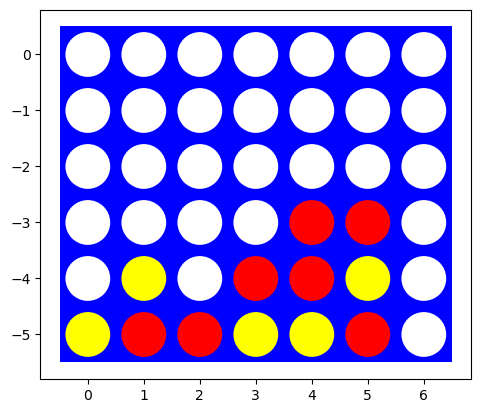

In [68]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 1, 1, 0],
             [ 0,-1, 0, 1, 1,-1, 0],
             [-1, 1, 1,-1,-1, 1, 0]]

visualize(raw_board)
board = np.array(raw_board)

In [69]:
action, time_taken, nodes_explored = agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {time_taken:.4f} seconds\nNodes explored: {nodes_explored}")

Next action: drop disc in column 4
Time taken: 0.0585 seconds
Nodes explored: 238


**Board 5:** Second Left Diagonal

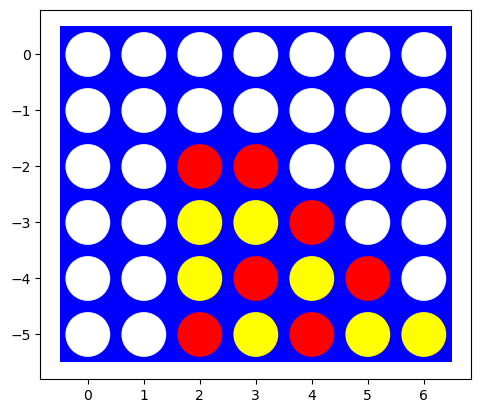

In [70]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 1, 1, 0, 0, 0],
             [ 0, 0,-1,-1, 1, 0, 0],
             [ 0, 0,-1, 1,-1, 1, 0],
             [ 0, 0, 1,-1, 1,-1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [71]:
action, time_taken, nodes_explored = agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {time_taken:.4f} seconds\nNodes explored: {nodes_explored}")

Next action: drop disc in column 2
Time taken: 0.0373 seconds
Nodes explored: 120


**Results**

My agent worked well for most of the situations I threw at it. However, it failed to identify the next move (a winning move) in the "Nearly Full Board" and my "Right Diagonal" board. I am not sure why this would be the case, especially since it correctly identified the winning move in both "Left Diagonal" boards.

_______________________________________

**Time**

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

**Board 6:** Four Columns

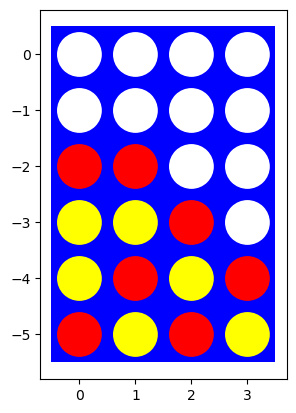

In [72]:
raw_board = [[ 0, 0, 0, 0],
             [ 0, 0, 0, 0],
             [ 1, 1, 0, 0],
             [-1,-1, 1, 0],
             [-1, 1,-1, 1],
             [ 1,-1, 1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [73]:
action, four_time_taken, four_nodes_explored = agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {four_time_taken:.4f} seconds\nNodes explored: {four_nodes_explored}")

Next action: drop disc in column 0
Time taken: 0.0000 seconds
Nodes explored: 13


**Board 7:** Five Columns

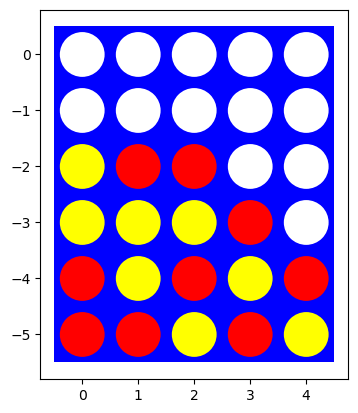

In [74]:
raw_board = [[ 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0],
             [-1, 1, 1, 0, 0],
             [-1,-1,-1, 1, 0],
             [ 1,-1, 1,-1, 1],
             [ 1, 1,-1, 1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [75]:
action, five_time_taken, five_nodes_explored = agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {five_time_taken:.4f} seconds\nNodes explored: {five_nodes_explored}")

Next action: drop disc in column 1
Time taken: 0.0000 seconds
Nodes explored: 40


**Board 8:** Six Columns

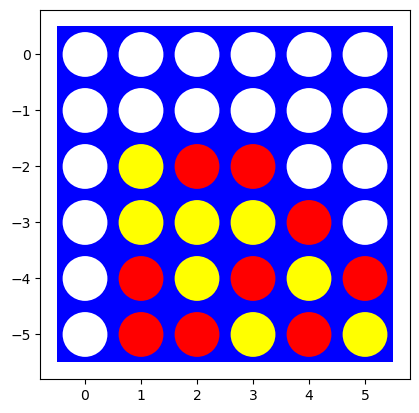

In [76]:
raw_board = [[ 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0],
             [ 0,-1,-1,-1, 1, 0],
             [ 0, 1,-1, 1,-1, 1],
             [ 0, 1, 1,-1, 1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [77]:
action, six_time_taken, six_nodes_explored = agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {six_time_taken:.4f} seconds\nNodes explored: {six_nodes_explored}")

Next action: drop disc in column 2
Time taken: 0.0367 seconds
Nodes explored: 108


**Board 9:** Seven Columns

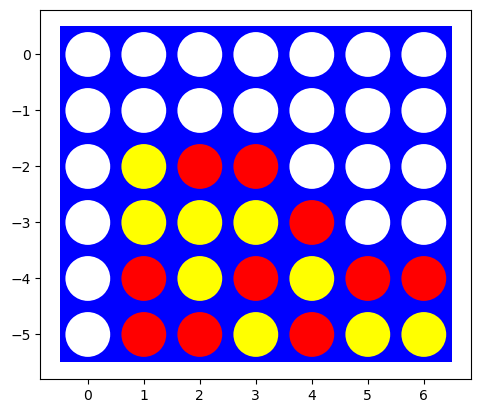

In [78]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0, 0],
             [ 0,-1,-1,-1, 1, 0, 0],
             [ 0, 1,-1, 1,-1, 1, 1],
             [ 0, 1, 1,-1, 1,-1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [79]:
action, seven_time_taken, seven_nodes_explored = agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {seven_time_taken:.4f} seconds\nNodes explored: {seven_nodes_explored}")

Next action: drop disc in column 2
Time taken: 0.0469 seconds
Nodes explored: 147


**Board 10:** Eight Columns

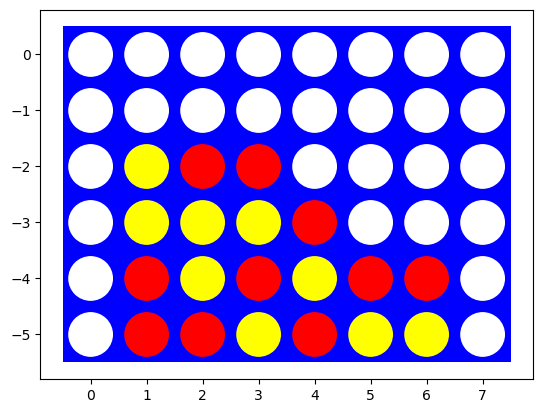

In [80]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0, 0, 0],
             [ 0,-1,-1,-1, 1, 0, 0, 0],
             [ 0, 1,-1, 1,-1, 1, 1, 0],
             [ 0, 1, 1,-1, 1,-1,-1, 0]]

visualize(raw_board)
board = np.array(raw_board)

In [81]:
action, eight_time_taken, eight_nodes_explored = agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {eight_time_taken:.4f} seconds\nNodes explored: {eight_nodes_explored}")

Next action: drop disc in column 2
Time taken: 0.0678 seconds
Nodes explored: 192


**Board 11:** Nine Columns

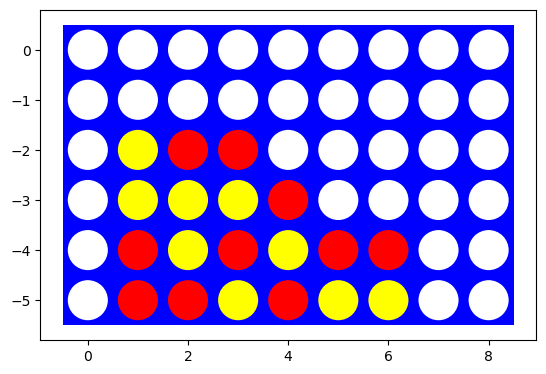

In [82]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0, 0, 0, 0],
             [ 0,-1,-1,-1, 1, 0, 0, 0, 0],
             [ 0, 1,-1, 1,-1, 1, 1, 0, 0],
             [ 0, 1, 1,-1, 1,-1,-1, 0, 0]]

visualize(raw_board)
board = np.array(raw_board)

In [83]:
action, nine_time_taken, nine_nodes_explored = agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {nine_time_taken:.4f} seconds\nNodes explored: {nine_nodes_explored}")

Next action: drop disc in column 2
Time taken: 0.0850 seconds
Nodes explored: 244


**Board 12:** Ten Colmns

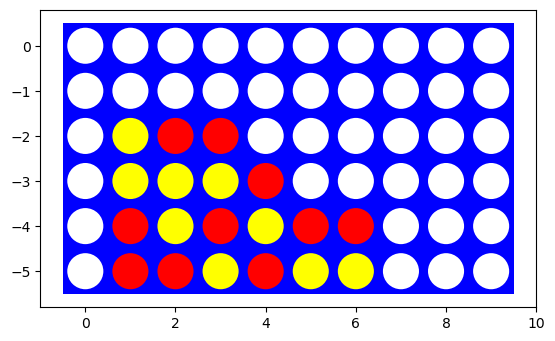

In [84]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0, 0, 0, 0, 0],
             [ 0,-1,-1,-1, 1, 0, 0, 0, 0, 0],
             [ 0, 1,-1, 1,-1, 1, 1, 0, 0, 0],
             [ 0, 1, 1,-1, 1,-1,-1, 0, 0, 0]]

visualize(raw_board)
board = np.array(raw_board)

In [85]:
action, ten_time_taken, ten_nodes_explored = agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {ten_time_taken:.4f} seconds\nNodes explored: {ten_nodes_explored}")

Next action: drop disc in column 2
Time taken: 0.1175 seconds
Nodes explored: 299


In [86]:
x = [4, 5, 6, 7, 8, 9, 10]
y1 = [four_time_taken, five_time_taken, six_time_taken, seven_time_taken, eight_time_taken, nine_time_taken, ten_time_taken]
y2 = [four_nodes_explored, five_nodes_explored, six_nodes_explored, seven_nodes_explored, eight_nodes_explored, nine_nodes_explored, ten_nodes_explored]

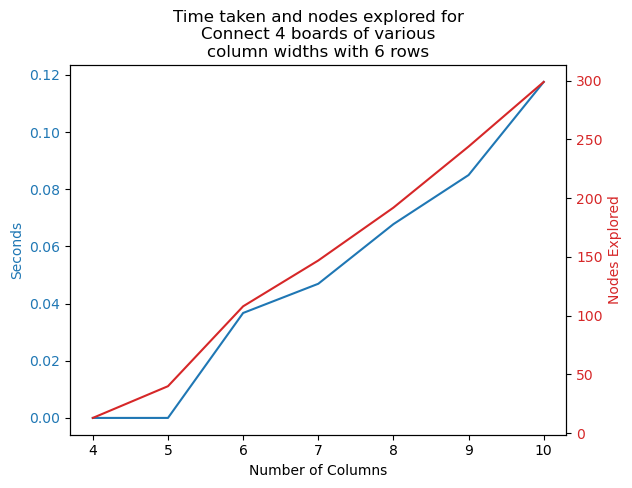

In [87]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Number of Columns')
ax1.set_ylabel('Seconds', color='tab:blue')
ax1.plot(x, y1, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  
ax2.set_ylabel('Nodes Explored', color='tab:red')  
ax2.plot(x, y2, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Time taken and nodes explored for\nConnect 4 boards of various\ncolumn widths with 6 rows')
plt.show()

It appears that the time taken and number of nodes needed to explore grows linearly as we add a columns

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

**Center Column Ordering:**

One approach to take is to start with the center column first (since it is known that the first player to place a disc in the center column does in fact have an advantage in winning the game)

In [88]:
class OrderedMinimaxAgent(MinimaxAgent):
    @staticmethod
    def ordered_actions(s):
        center = s.shape[1] // 2
        return sorted(actions(s), key=lambda x: -abs(x - center))
  
    def minimax(self, state, depth, alpha, beta, maximizing_player):
        if terminal(state) or depth == 0:
            return utility(state, self.player), None, 1

        if maximizing_player:
            max_eval = float('-inf')
            best_action = None
            nodes_explored = 0
            for action in self.ordered_actions(state):
                eval, _, nodes = super().minimax(result(state, action, self.player), depth - 1, alpha, beta, False)
                nodes_explored += nodes
                if eval > max_eval:
                    max_eval = eval
                    best_action = action
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval, best_action, nodes_explored
        else:
            min_eval = float('inf')
            best_action = None
            nodes_explored = 0
            for action in self.ordered_actions(state):
                eval, _, nodes = super().minimax(result(state, action, -self.player), depth - 1, alpha, beta, True)
                nodes_explored += nodes
                if eval < min_eval:
                    min_eval = eval
                    best_action = action
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval, best_action, nodes_explored

In [89]:
ordered_agent = OrderedMinimaxAgent(player=1)

*Four Columns*

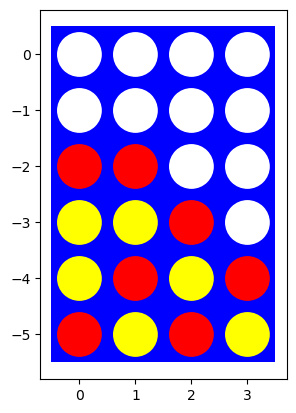

In [90]:
raw_board = [[ 0, 0, 0, 0],
             [ 0, 0, 0, 0],
             [ 1, 1, 0, 0],
             [-1,-1, 1, 0],
             [-1, 1,-1, 1],
             [ 1,-1, 1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [91]:
action, ordered_four_time_taken, ordered_four_nodes_explored = ordered_agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {ordered_four_time_taken:.4f} seconds\nNodes explored: {ordered_four_nodes_explored}")

Next action: drop disc in column 0
Time taken: 0.0000 seconds
Nodes explored: 13


*Five Columns*

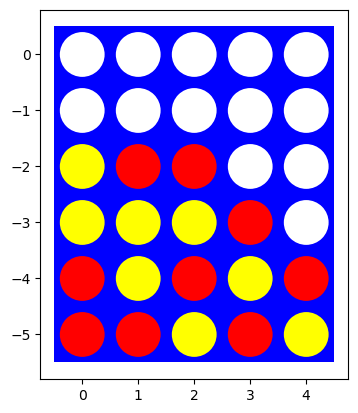

In [92]:
raw_board = [[ 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0],
             [-1, 1, 1, 0, 0],
             [-1,-1,-1, 1, 0],
             [ 1,-1, 1,-1, 1],
             [ 1, 1,-1, 1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [93]:
action, ordered_five_time_taken, ordered_five_nodes_explored = ordered_agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {ordered_five_time_taken:.4f} seconds\nNodes explored: {ordered_five_nodes_explored}")

Next action: drop disc in column 4
Time taken: 0.0081 seconds
Nodes explored: 52


*Six Columns*

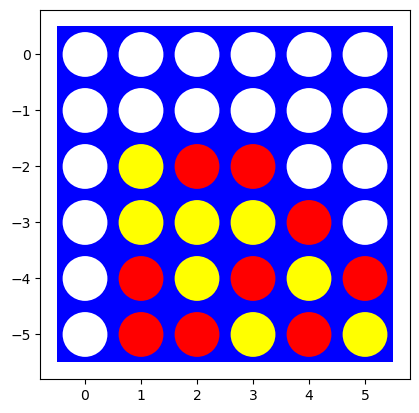

In [94]:
raw_board = [[ 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0],
             [ 0,-1,-1,-1, 1, 0],
             [ 0, 1,-1, 1,-1, 1],
             [ 0, 1, 1,-1, 1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [95]:
action, ordered_six_time_taken, ordered_six_nodes_explored = ordered_agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {ordered_six_time_taken:.4f} seconds\nNodes explored: {ordered_six_nodes_explored}")

Next action: drop disc in column 5
Time taken: 0.0327 seconds
Nodes explored: 126


*Seven Columns*

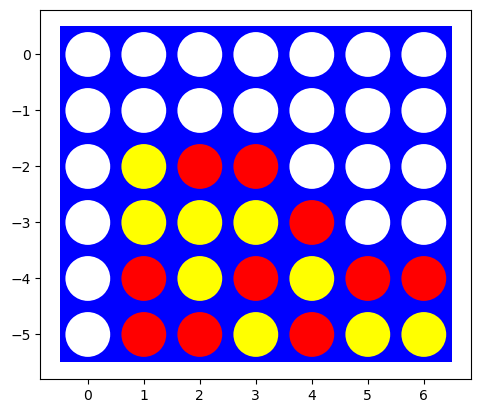

In [96]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0, 0],
             [ 0,-1,-1,-1, 1, 0, 0],
             [ 0, 1,-1, 1,-1, 1, 1],
             [ 0, 1, 1,-1, 1,-1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [97]:
action, ordered_seven_time_taken, ordered_seven_nodes_explored = ordered_agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {ordered_seven_time_taken:.4f} seconds\nNodes explored: {ordered_seven_nodes_explored}")

Next action: drop disc in column 5
Time taken: 0.0680 seconds
Nodes explored: 196


*Eight Columns*

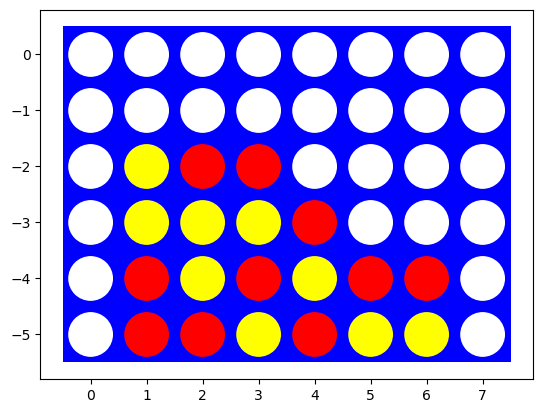

In [98]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0, 0, 0],
             [ 0,-1,-1,-1, 1, 0, 0, 0],
             [ 0, 1,-1, 1,-1, 1, 1, 0],
             [ 0, 1, 1,-1, 1,-1,-1, 0]]

visualize(raw_board)
board = np.array(raw_board)

In [99]:
action, ordered_eight_time_taken, ordered_eight_nodes_explored = ordered_agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {ordered_eight_time_taken:.4f} seconds\nNodes explored: {ordered_eight_nodes_explored}")

Next action: drop disc in column 2
Time taken: 0.0798 seconds
Nodes explored: 206


*Nine Columns*

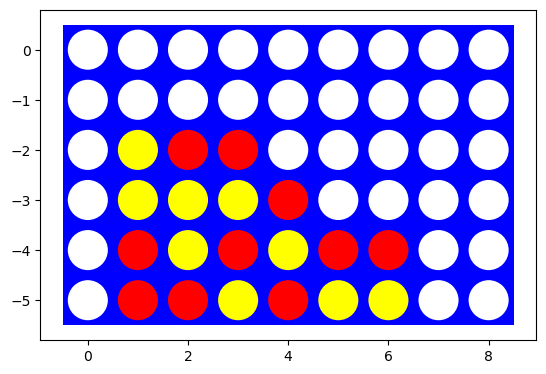

In [100]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0, 0, 0, 0],
             [ 0,-1,-1,-1, 1, 0, 0, 0, 0],
             [ 0, 1,-1, 1,-1, 1, 1, 0, 0],
             [ 0, 1, 1,-1, 1,-1,-1, 0, 0]]

visualize(raw_board)
board = np.array(raw_board)

In [101]:
action, ordered_nine_time_taken, ordered_nine_nodes_explored = ordered_agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {ordered_nine_time_taken:.4f} seconds\nNodes explored: {ordered_nine_nodes_explored}")

Next action: drop disc in column 2
Time taken: 0.0993 seconds
Nodes explored: 292


*Ten Columns*

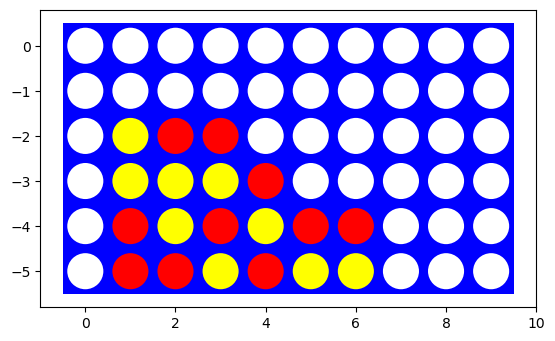

In [102]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0, 0, 0, 0, 0],
             [ 0,-1,-1,-1, 1, 0, 0, 0, 0, 0],
             [ 0, 1,-1, 1,-1, 1, 1, 0, 0, 0],
             [ 0, 1, 1,-1, 1,-1,-1, 0, 0, 0]]

visualize(raw_board)
board = np.array(raw_board)

In [103]:
action, ordered_ten_time_taken, ordered_ten_nodes_explored = ordered_agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {ordered_ten_time_taken:.4f} seconds\nNodes explored: {ordered_ten_nodes_explored}")

Next action: drop disc in column 2
Time taken: 0.1152 seconds
Nodes explored: 332


I am not sure why, but my center-ordered agent incorrectly identified the next move for the five, six, and seven column boards (but not for the four, eight, nine, and ten boards).

In [104]:
y3 = [ordered_four_time_taken, ordered_five_time_taken, ordered_six_time_taken, ordered_seven_time_taken, ordered_eight_time_taken, ordered_nine_time_taken, ordered_ten_time_taken]

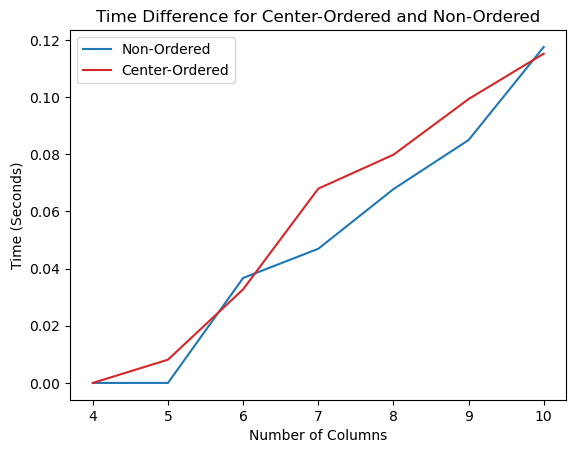

In [105]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Number of Columns')
ax1.set_ylabel('Time (Seconds)')
ax1.plot(x, y1, color='tab:blue', label='Non-Ordered')
ax1.plot(x, y3, color='tab:red', label='Center-Ordered')
ax1.tick_params(axis='y')

plt.title('Time Difference for Center-Ordered and Non-Ordered')
plt.legend(loc='best')
plt.show()

It appears that my implementation of a center-ordered search is not better than the non-ordered. In reality, I believe there is just a problem with how I implemented the center-ordered search.

### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

**Depth Limit**

I am already using a depth limit of 4 (in-built to the 'MinimaxAgent' class), which limits how many layers deep the agent will explore at a time. This keeps it from having to calculate all possible game boards (which is especially necessary when the board is empty).

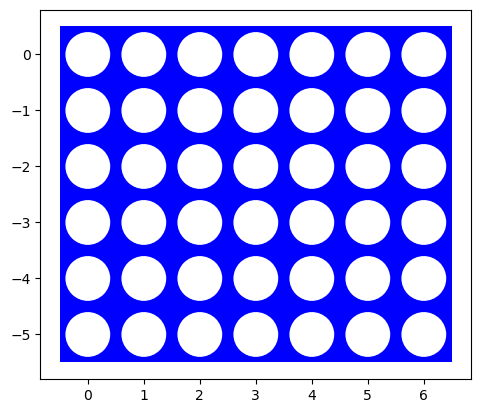

In [106]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0]]

visualize(raw_board)
board = np.array(raw_board)

In [107]:
action, time_taken, nodes_explored = agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {time_taken:.4f} seconds\nNodes explored: {nodes_explored}")

Next action: drop disc in column 0
Time taken: 0.0081 seconds
Nodes explored: 97


Because the depth limit is set to 4, the agent only took 0.005 seconds to find a suitable next move (place disc in column 0).

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [108]:
def better_play_game(agent1, agent2, board_size=(6, 7), num_games=100):
    results = {"agent1_wins": 0, "agent2_wins": 0, "draws": 0}

    for _ in range(num_games):
        board = empty_board()
        player_turn = 1

        while not terminal(board):
            if player_turn == 1:
                action = agent1(board)
            else:
                action = agent2(board)

            if action is not None:
                board = result(board, action, player_turn)

            if terminal(board):
                outcome = utility(board, 1)
                if outcome > 0:
                    results["agent1_wins"] += 1
                elif outcome < 0:
                    results["agent2_wins"] += 1
                else:
                    results["draws"] += 1

            player_turn *= -1  # Switch turn

    return results

def minimax_action(board, player=1):
    minimax_agent = MinimaxAgent(player)
    action, _, _ = minimax_agent.choose_action(board)
    return action

In [109]:
game_results = better_play_game(minimax_action, random_player, num_games=100)
print(game_results)

{'agent1_wins': 100, 'agent2_wins': 0, 'draws': 0}


The Minimax agent ('agent1') won all 100 games, with the random agent ('agent2') winning 0

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

In [120]:
class HeuristicMinimaxAgent(MinimaxAgent):
    def __init__(self, player, depth_limit=4):
        super().__init__(player)
        self.depth_limit = depth_limit

    def heuristic_evaluation(self, board):
        score = 0
        rows, cols = board.shape
        player_disc = self.player
        opponent_disc = -self.player

        def evaluate_line(line):
            player_count = line.count(player_disc)
            opponent_count = line.count(opponent_disc)
            if player_count > 0 and opponent_count > 0:
                return 0
            return player_count - opponent_count

        # Checking for horizontals
        for row in range(rows):
            for col in range(cols - 3):
                line = [board[row, c] for c in range(col, col + 4)]
                score += evaluate_line(line)

        # Checking for verticals
        for col in range(cols):
            for row in range(rows - 3):
                line = [board[r, col] for r in range(row, row + 4)]
                score += evaluate_line(line)
                
        # Checking for diagonals
        for row in range(rows - 3):
            for col in range(cols - 3):
                down_right = [board[row + i, col + i] for i in range(4)]
                up_right = [board[row + 3 - i, col + i] for i in range(4)]
                score += evaluate_line(down_right)
                score += evaluate_line(up_right)
                
        return score

    def minimax(self, state, alpha, beta, maximizing_player, depth):
        if terminal(state) or depth == 0:
            if terminal(state):
                return utility(state, self.player), None, 1
            else:
                return self.heuristic_evaluation(state), None, 1

        if maximizing_player:
            max_eval = float('-inf')
            best_action = None
            nodes_explored = 0
            for action in actions(state):
                eval, _, nodes = self.minimax(result(state, action, self.player), alpha, beta, False, depth - 1)
                nodes_explored += nodes
                if eval > max_eval:
                    max_eval = eval
                    best_action = action
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval, best_action, nodes_explored
        else:
            min_eval = float('inf')
            best_action = None
            nodes_explored = 0
            for action in actions(state):
                eval, _, nodes = self.minimax(result(state, action, -self.player), alpha, beta, True, depth - 1)
                nodes_explored += nodes
                if eval < min_eval:
                    min_eval = eval
                    best_action = action
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval, best_action, nodes_explored

    def choose_action(self, state):
        start_time = time.time()
        _, action, nodes_explored = self.minimax(state, float('-inf'), float('inf'), True, self.depth_limit)
        end_time = time.time()
        time_taken = end_time - start_time
        return action, time_taken, nodes_explored

In [121]:
heuristic_agent_1 = HeuristicMinimaxAgent(player=1)

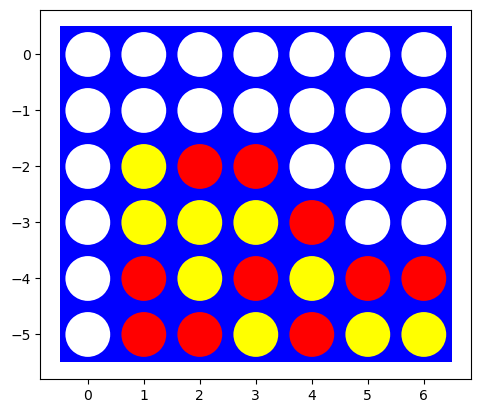

In [122]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0, 0],
             [ 0,-1,-1,-1, 1, 0, 0],
             [ 0, 1,-1, 1,-1, 1, 1],
             [ 0, 1, 1,-1, 1,-1,-1]]

visualize(raw_board)
board = np.array(raw_board)

*With Heuristic*

In [113]:
action, time_taken, nodes_explored = heuristic_agent_1.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {time_taken:.4f} seconds\nNodes explored: {nodes_explored}")

Next action: drop disc in column 2
Time taken: 0.2039 seconds
Nodes explored: 425


*Without Heuristic*

In [123]:
action, time_taken, nodes_explored = agent.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {time_taken:.4f} seconds\nNodes explored: {nodes_explored}")

Next action: drop disc in column 2
Time taken: 0.0158 seconds
Nodes explored: 147


I am not sure why my heuristic agent was slower.

### Cutting off search [10 points]

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [124]:
for depth_limit in range(2, 8):
    heuristic_agent_2 = HeuristicMinimaxAgent(player=1, depth_limit=depth_limit)
    action, time_taken, nodes_explored = heuristic_agent_2.choose_action(board)
    print(f"Depth Limit: {depth_limit}, Action: {action}, Time Taken: {time_taken:.4f} sec, Nodes Explored: {nodes_explored}")

Depth Limit: 2, Action: 4, Time Taken: 0.0070 sec, Nodes Explored: 31
Depth Limit: 3, Action: 4, Time Taken: 0.0250 sec, Nodes Explored: 174
Depth Limit: 4, Action: 2, Time Taken: 0.0982 sec, Nodes Explored: 425
Depth Limit: 5, Action: 4, Time Taken: 0.5145 sec, Nodes Explored: 2425
Depth Limit: 6, Action: 2, Time Taken: 0.4837 sec, Nodes Explored: 2343
Depth Limit: 7, Action: 1, Time Taken: 0.4002 sec, Nodes Explored: 1940


It appears that only two depths found the most advantageous next move (a winning connect 4) -- depths 4 and 6.

I also noticed that as the depth limit increased from 2 to 5 the number of nodes explored increased, but from 5 to 7 the number of nodes explored decreased.
_____________________________

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [125]:
for depth_limit in range(2, 8):
    agent = MinimaxAgent(player=1, depth_limit=depth_limit)
    action, time_taken, nodes_explored = agent.choose_action(board)
    print(f"Depth Limit: {depth_limit}, Action: {action}, Time Taken: {time_taken:.4f} sec, Nodes Explored: {nodes_explored}")

Depth Limit: 2, Action: 2, Time Taken: 0.0165 sec, Nodes Explored: 147
Depth Limit: 3, Action: 2, Time Taken: 0.0060 sec, Nodes Explored: 147
Depth Limit: 4, Action: 2, Time Taken: 0.0162 sec, Nodes Explored: 147
Depth Limit: 5, Action: 2, Time Taken: 0.0264 sec, Nodes Explored: 147
Depth Limit: 6, Action: 2, Time Taken: 0.0159 sec, Nodes Explored: 147
Depth Limit: 7, Action: 2, Time Taken: 0.0080 sec, Nodes Explored: 147


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

**Board 6:** Four Columns

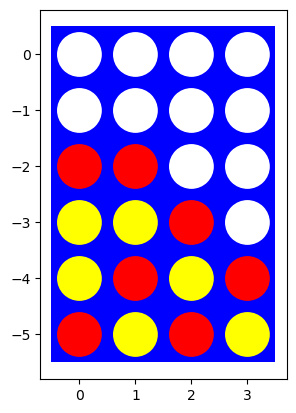

In [126]:
raw_board = [[ 0, 0, 0, 0],
             [ 0, 0, 0, 0],
             [ 1, 1, 0, 0],
             [-1,-1, 1, 0],
             [-1, 1,-1, 1],
             [ 1,-1, 1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [129]:
action, heur_four_time_taken, heur_four_nodes_explored = heuristic_agent_1.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {heur_four_time_taken:.4f} seconds\nNodes explored: {heur_four_nodes_explored}")

Next action: drop disc in column 2
Time taken: 0.0080 seconds
Nodes explored: 71


**Board 7:** Five Columns

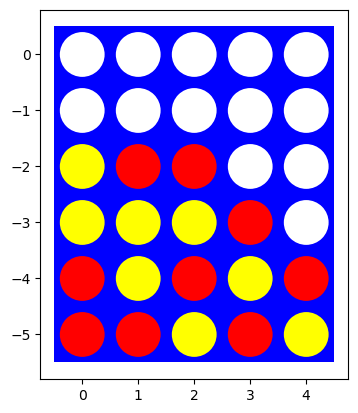

In [130]:
raw_board = [[ 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0],
             [-1, 1, 1, 0, 0],
             [-1,-1,-1, 1, 0],
             [ 1,-1, 1,-1, 1],
             [ 1, 1,-1, 1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [131]:
action, heur_five_time_taken, heur_five_nodes_explored = heuristic_agent_1.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {heur_five_time_taken:.4f} seconds\nNodes explored: {heur_five_nodes_explored}")

Next action: drop disc in column 3
Time taken: 0.0240 seconds
Nodes explored: 145


**Board 8:** Six Columns

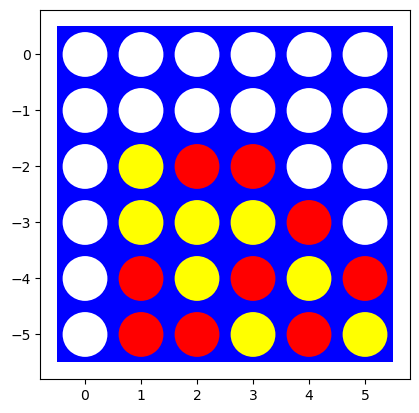

In [132]:
raw_board = [[ 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0],
             [ 0,-1,-1,-1, 1, 0],
             [ 0, 1,-1, 1,-1, 1],
             [ 0, 1, 1,-1, 1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [133]:
action, heur_six_time_taken, heur_six_nodes_explored = heuristic_agent_1.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {heur_six_time_taken:.4f} seconds\nNodes explored: {heur_six_nodes_explored}")

Next action: drop disc in column 2
Time taken: 0.0372 seconds
Nodes explored: 203


**Board 9:** Seven Columns

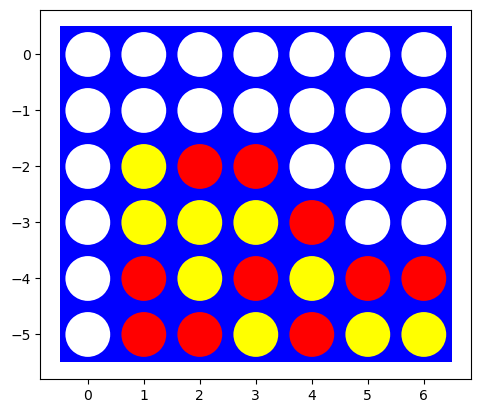

In [134]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0, 0],
             [ 0,-1,-1,-1, 1, 0, 0],
             [ 0, 1,-1, 1,-1, 1, 1],
             [ 0, 1, 1,-1, 1,-1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [135]:
action, heur_seven_time_taken, heur_seven_nodes_explored = heuristic_agent_1.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {heur_seven_time_taken:.4f} seconds\nNodes explored: {heur_seven_nodes_explored}")

Next action: drop disc in column 2
Time taken: 0.0827 seconds
Nodes explored: 425


**Board 10:** Eight Columns

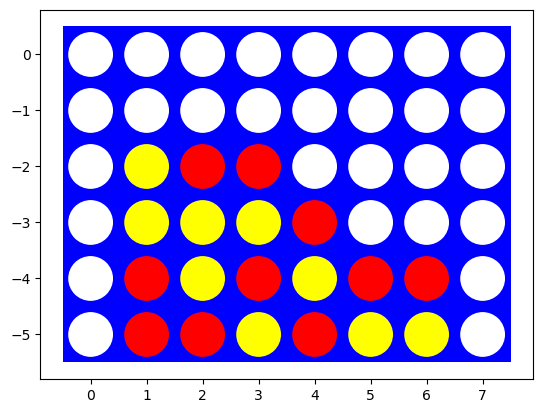

In [136]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0, 0, 0],
             [ 0,-1,-1,-1, 1, 0, 0, 0],
             [ 0, 1,-1, 1,-1, 1, 1, 0],
             [ 0, 1, 1,-1, 1,-1,-1, 0]]

visualize(raw_board)
board = np.array(raw_board)

In [137]:
action, heur_eight_time_taken, heur_eight_nodes_explored = heuristic_agent_1.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {heur_eight_time_taken:.4f} seconds\nNodes explored: {heur_eight_nodes_explored}")

Next action: drop disc in column 1
Time taken: 0.2041 seconds
Nodes explored: 891


**Board 11:** Nine Columns

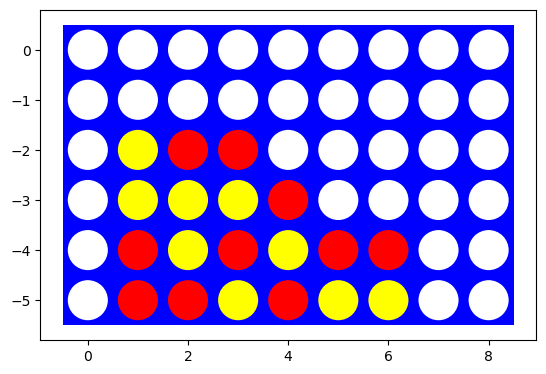

In [138]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0, 0, 0, 0],
             [ 0,-1,-1,-1, 1, 0, 0, 0, 0],
             [ 0, 1,-1, 1,-1, 1, 1, 0, 0],
             [ 0, 1, 1,-1, 1,-1,-1, 0, 0]]

visualize(raw_board)
board = np.array(raw_board)

In [139]:
action, heur_nine_time_taken, heur_nine_nodes_explored = heuristic_agent_1.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {heur_nine_time_taken:.4f} seconds\nNodes explored: {heur_nine_nodes_explored}")

Next action: drop disc in column 6
Time taken: 0.4571 seconds
Nodes explored: 1664


**Board 12:** Ten Colmns

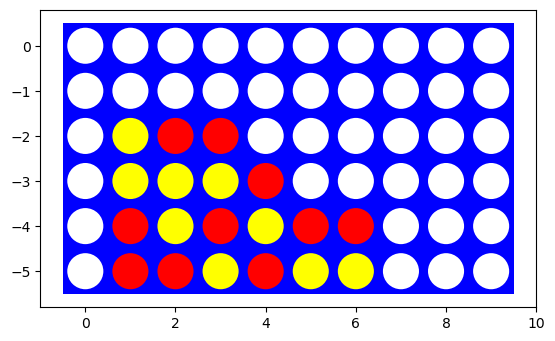

In [140]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0, 0, 0, 0, 0],
             [ 0,-1,-1,-1, 1, 0, 0, 0, 0, 0],
             [ 0, 1,-1, 1,-1, 1, 1, 0, 0, 0],
             [ 0, 1, 1,-1, 1,-1,-1, 0, 0, 0]]

visualize(raw_board)
board = np.array(raw_board)

In [141]:
action, heur_ten_time_taken, heur_ten_nodes_explored = heuristic_agent_1.choose_action(board)
print(f"Next action: drop disc in column {action}\nTime taken: {heur_ten_time_taken:.4f} seconds\nNodes explored: {heur_ten_nodes_explored}")

Next action: drop disc in column 6
Time taken: 0.6021 seconds
Nodes explored: 2040


My heuristic agent performed massively worse than my non-heuristic agent. It failed to identify the correct next move in almost ever width board and explored far more nodes than the non-heuristic agent (meaning it was far slower).

I am not sure what I did wrong with the heuristic agent here.

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [142]:
def heur_minimax_action(board, player=2):
    heur_minimax_agent = HeuristicMinimaxAgent(player)
    action, _, _ = heur_minimax_agent.choose_action(board)
    return action

In [144]:
game_results = better_play_game(minimax_action, heur_minimax_action, num_games=10)
print(game_results)

{'agent1_wins': 10, 'agent2_wins': 0, 'draws': 0}


Since I was having trouble with my heuristic agent, I instead chose to see how my original agent would perform against my new heuristic agent. I expected it would not beat the original agent at all since it was performing so much worse.

This assumption was given some evidence of being true in that my original agent ('agent1') won 10 out of 10 games and the heuristic agent ('agent2') won 0.

## Challenge task [+ 10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+10 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above. 

In [145]:
class PureMonteCarloAgent:
    def __init__(self, player, num_simulations=100):
        self.player = player
        self.num_simulations = num_simulations

    def random_playout(self, state):
        current_player = self.player
        while not terminal(state):
            possible_actions = actions(state)
            if not possible_actions:
                break  # Draw
            action = random.choice(possible_actions)
            state = result(state, action, current_player)
            current_player *= -1
        return utility(state, self.player)

    def choose_action(self, state):
        action_scores = {action: 0 for action in actions(state)}

        for action in action_scores:
            for _ in range(self.num_simulations):
                simulated_state = result(state.copy(), action, self.player)
                action_scores[action] += self.random_playout(simulated_state)

        best_action = max(action_scores, key=action_scores.get)
        return best_action

In [147]:
monte_carlo_agent = PureMonteCarloAgent(player=1, num_simulations=100)

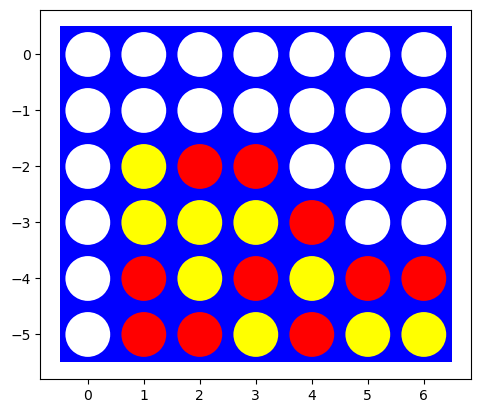

In [146]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0, 0],
             [ 0,-1,-1,-1, 1, 0, 0],
             [ 0, 1,-1, 1,-1, 1, 1],
             [ 0, 1, 1,-1, 1,-1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [150]:
best_action = monte_carlo_agent.choose_action(board)
print(f"Next best action:\nDrop disc in column {best_action}")

Next best action:
Drop disc in column 2


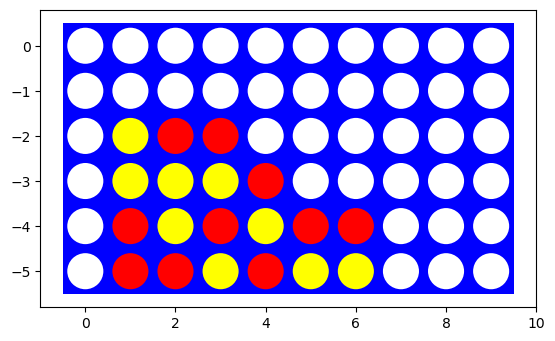

In [151]:
raw_board = [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 1, 1, 0, 0, 0, 0, 0, 0],
             [ 0,-1,-1,-1, 1, 0, 0, 0, 0, 0],
             [ 0, 1,-1, 1,-1, 1, 1, 0, 0, 0],
             [ 0, 1, 1,-1, 1,-1,-1, 0, 0, 0]]

visualize(raw_board)
board = np.array(raw_board)

In [152]:
best_action = monte_carlo_agent.choose_action(board)
print(f"Next best action:\nDrop disc in column {best_action}")

Next best action:
Drop disc in column 2


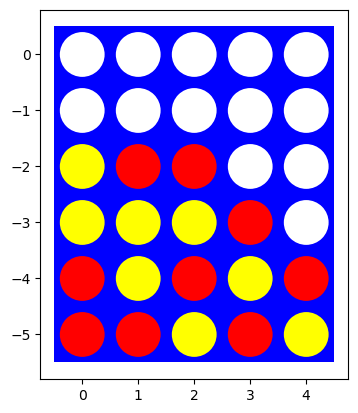

In [160]:
raw_board = [[ 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0],
             [-1, 1, 1, 0, 0],
             [-1,-1,-1, 1, 0],
             [ 1,-1, 1,-1, 1],
             [ 1, 1,-1, 1,-1]]

visualize(raw_board)
board = np.array(raw_board)

In [161]:
best_action = monte_carlo_agent.choose_action(board)
print(f"Next best action:\nDrop disc in column {best_action}")

Next best action:
Drop disc in column 1


As we can see, the Pure Monte Carlo agent correctly chose the right next best action for the boards that my other agents previously struggled with.

### Best First Move

Use Oure Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

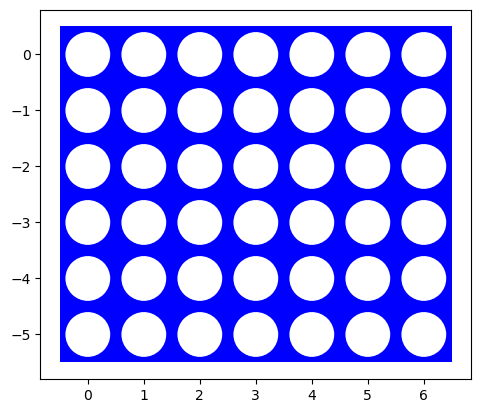

In [162]:
board = empty_board()
visualize(board)

In [163]:
best_action = monte_carlo_agent.choose_action(board)
print(f"Next best action:\nDrop disc in column {best_action}")

Next best action:
Drop disc in column 3


The Pure Monte Carolo agent, on a completely empty standard Connect 4 board, chose the center column (column 3) as the best opening move. 

This is interesting because it is known that this is actually the best first move a player can make in the Connect 4 game (since it is a 'solved' game).